In [1]:
import xarray as xr
import rasterio as rio
import rioxarray
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# functions to load interferogram tifs to xarray
def xr_read_geotif(geotif_file_path, masked=True):
    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    del ds.coords["band"]

    return ds

def combine_ds(data_dir, file_type='horizontal_velocity'):
    datasets = []

    tif_list = glob(f'{data_dir}/S2*{file_type}.tif')
    for tif_path in tif_list:
        dates = tif_path.split('/')[-1][3:24] #parse filename for dates
        start_date = datetime.strptime(dates[:10], '%Y-%m-%d')
        end_date = datetime.strptime(dates[11:], '%Y-%m-%d')
        t_baseline = end_date - start_date
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"dates": dates})
        src = src.expand_dims("dates")
        
        src = src.assign_coords(start_date = ('dates', [start_date]))
        src = src.assign_coords(end_date = ('dates', [end_date]))
        src = src.assign_coords(t_baseline = ('dates', [t_baseline]))

        src = src.rename({'band1':file_type})
        
        datasets.append(src)
       
    ds = xr.concat(datasets, dim="dates", combine_attrs="no_conflicts") #create dataset
    ds = ds.sortby('dates')

    return ds 

In [3]:
# read in tifs
veloc_ds = combine_ds('../data/*', 'horizontal_velocity')

In [183]:
ref_point = veloc_ds.isel(x=slice(0, 300), y=slice(len(veloc_ds.y)-300, len(veloc_ds.y))).horizontal_velocity.median(dim=['x', 'y'])
veloc_ds['horizontal_veloc_corrected'] = veloc_ds['horizontal_velocity'] - ref_point
veloc_ds['horizontal_veloc_corrected'] = xr.where(veloc_ds['horizontal_veloc_corrected'] < 0, 0, veloc_ds['horizontal_veloc_corrected'])
veloc_ds['horizontal_veloc_corrected'] = veloc_ds['horizontal_veloc_corrected'].where(veloc_ds['horizontal_veloc_corrected'] < 700)

In [ ]:
dates_to_remove = ["2017-07-17_2017-07-22",
                  ]

In [ ]:
dates_to_keep = [

"2017-07-22_2017-09-28"


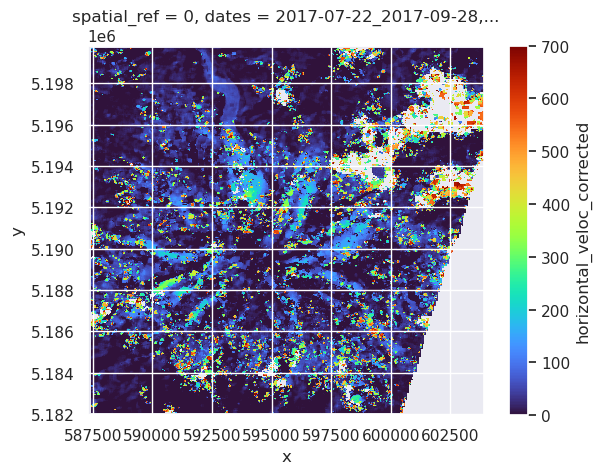

In [212]:
index = 13
print(f'"{veloc_ds.isel(dates=index).dates.item()}"')
veloc_ds.isel(dates=index)['horizontal_veloc_corrected'].plot.imshow(vmin=0, vmax=700, cmap='turbo')

In [216]:
# calculate and save median velocity
veloc_da_median = veloc_ds.horizontal_veloc_corrected.median(dim='dates')
veloc_da_median.rio.to_raster('median_horizontal_velocity_magnitude.tif')
# save standard deviation of velocity
veloc_da_stdev = veloc_ds.horizontal_veloc_corrected.std(dim='dates')
veloc_da_stdev.rio.to_raster('stdev_horizontal_velocity_magnitude.tif')
# save valid velocity pixel count
veloc_da_count = veloc_ds.horizontal_veloc_corrected.count(dim='dates')
veloc_da_count.rio.to_raster('count_horizontal_velocity_magnitude.tif')

/mnt/working/brencher/sw/miniconda3/envs/image-correlation/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


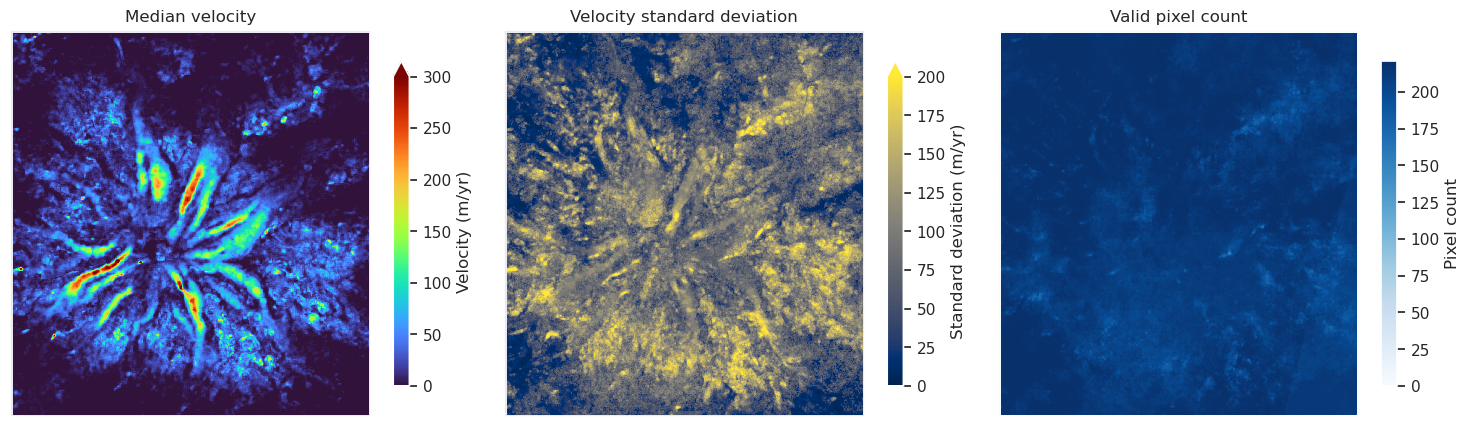

In [215]:
sns.set_theme()
f, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
veloc_da_median.plot(ax=ax[0], vmin=0, vmax=300, cmap='turbo', cbar_kwargs= {'shrink':0.7, 'label':'Velocity (m/yr)'})
veloc_da_stdev.plot(ax=ax[1], vmin=0, vmax=200, cmap='cividis', cbar_kwargs= {'shrink':0.7, 'label':'Standard deviation (m/yr)'})
veloc_da_count.plot(ax=ax[2], vmin=0, cmap='Blues', cbar_kwargs= {'shrink':0.7, 'label':'Pixel count'})
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
ax[0].set_title(f'Median velocity')
ax[1].set_title(f'Velocity standard deviation')
ax[2].set_title(f'Valid pixel count')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_ylabel('')
f.tight_layout()

f.savefig('../figs/velocity_summary_statistics.png', dpi=400)